# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [0]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [3]:
df.shape

(690, 16)

In [0]:
column_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','approved']
df.columns = column_names

In [5]:
df.sample(5)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
188,a,28.67,1.040,u,g,c,v,2.50,t,t,5,t,g,00300,1430,+
515,b,?,10.500,u,g,x,v,6.50,t,f,0,f,g,00000,0,+
506,a,18.92,9.000,u,g,aa,v,0.75,t,t,2,f,g,00088,591,+
282,b,17.67,4.460,u,g,c,v,0.25,f,f,0,f,s,00080,0,-
575,b,32.25,0.165,y,p,c,h,3.25,t,t,1,t,g,00432,8000,+


In [6]:
df['d'].value_counts()

u    519
y    163
?      6
l      2
Name: d, dtype: int64

In [0]:
import numpy as np
df = df.replace('?', np.NaN)
df = df.replace('+', 1)
df = df.replace('-', 0)

In [34]:
df.isna().sum()

a           12
b           12
c            0
d            6
e            6
f            9
g            9
h            0
i            0
j            0
k            0
l            0
m            0
n           13
o            0
approved     0
dtype: int64

In [35]:
df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,1


In [0]:
df.o.astype(float, copy=False)

In [11]:
df.head(4)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.54,u,g,w,v,3.75,t,t,5,t,g,00100,3,+


In [12]:
type(df.o[1])

numpy.int64

In [0]:
df.o = df.o.astype(float, copy=False)
df.n = df.n.astype(float, copy=False)
df.k = df.k.astype(float, copy=False)

In [14]:
df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,+


#DONE

## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [37]:
df_yes = df[df['approved'] == 1]
df_no = df[df['approved'] == 0]
df_no.head(1)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
70,b,32.33,7.5,u,g,e,bb,1.585,t,f,0.0,t,s,420.0,0.0,0


In [0]:
import matplotlib.pyplot as plt

In [17]:
#!pip install -U seaborn
!pip install seaborn==0.9.0


In [18]:
import seaborn as sns
sns.__version__

'0.9.0'

In [0]:
a = df_yes['n'].mean()

In [38]:
df.head(1)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.0,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,1


In [0]:
#Boring
sns.countplot(x='approved', hue='a', data=df)

In [0]:
##return to if you have too much time on your hands
sns.countplot(x='approved', hue='d', data=df)

In [0]:
#return to if you have too much time on your hands
sns.countplot(x='approved', hue='e', data=df)

In [0]:
#There's lower hanging fruit elsewhere
sns.countplot(x='approved', hue='f', data=df)

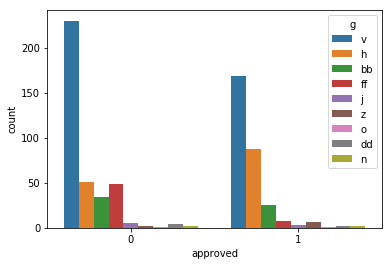

In [45]:
sns.countplot(x='approved', hue='g', data=df)

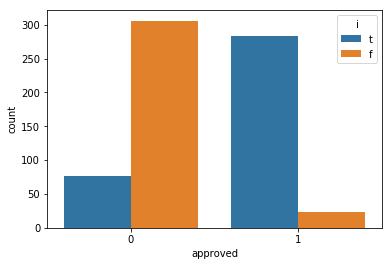

In [46]:
sns.countplot(x='approved', hue='i', data=df)

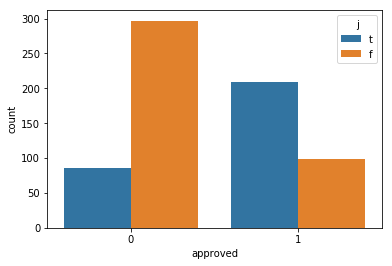

In [47]:
sns.countplot(x='approved', hue='j', data=df)

In [0]:
#Boring
sns.countplot(x='approved', hue='l', data=df)

In [0]:
#Boring
sns.countplot(x='approved', hue='m', data=df)

In [52]:
df.head(1)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.0,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,1


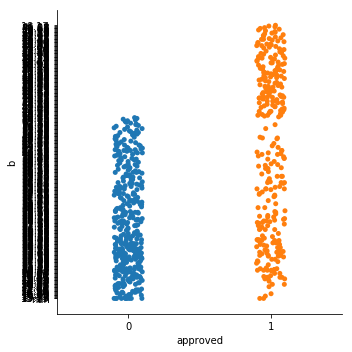

In [67]:
sns.catplot(x="approved", y="b", data=df)

In [0]:
#Boring
sns.catplot(x="approved", y="c", data=df)

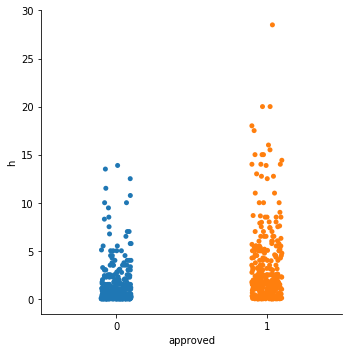

In [64]:
sns.catplot(x="approved", y="h", data=df)

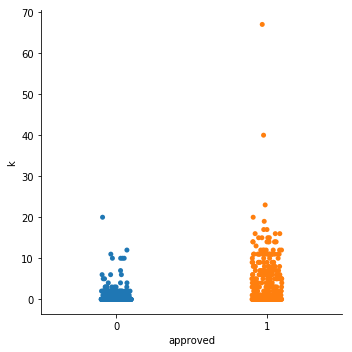

In [63]:
sns.catplot(x="approved", y="k", data=df)
#Guess: age with y axis representing years over 18?

In [0]:
#Boring
sns.catplot(x="approved", y="n", data=df)

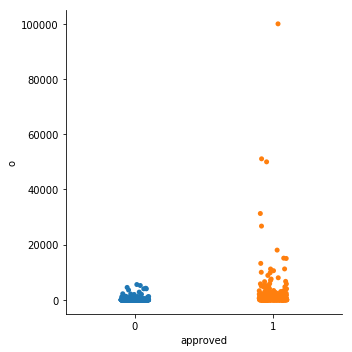

In [71]:
sns.catplot(x="approved", y="o", data=df)
#So this looks like low hanging fruit for income.
#I'm guessing monthly or weekly due to the clustering around the bottom
#Otherwise they may have done some sort of basic math transformation on the data

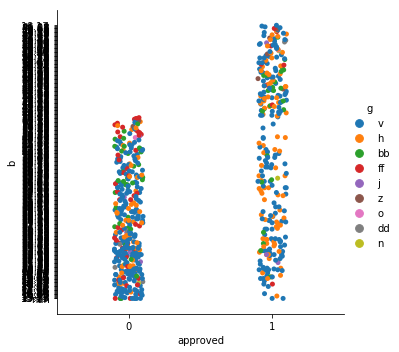

In [84]:
sns.catplot(x="approved", y="b", hue='g', data=df)


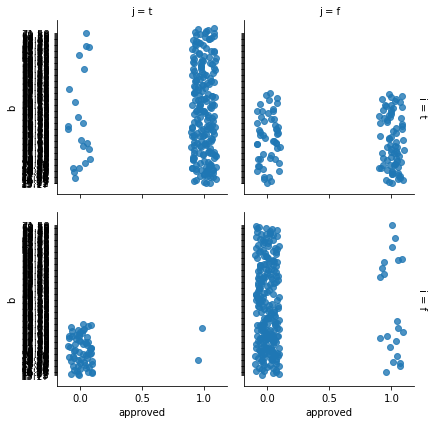

In [86]:
g = sns.FacetGrid(df, row="i", col="j", margin_titles=True)
g.map(sns.regplot, "approved", "b", fit_reg=False, x_jitter=.1);

In [0]:
#stats time!

In [0]:
from scipy import stats

In [90]:
df.head(1)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,approved
0,b,30.83,0.0,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,1


In [121]:
stats.ttest_ind(df_yes['h'], df_no['h'])

Ttest_indResult(statistic=8.935819983773698, pvalue=3.6710537401601785e-18)

In [122]:
y = df['k']
y.dropna()
stats.ttest_ind(df_yes['k'], df_no['k'])

Ttest_indResult(statistic=11.667004222431277, pvalue=7.957718568079967e-29)

In [119]:
xx = df_yes['i'].value_counts()
stats.chisquare(xx)

Power_divergenceResult(statistic=221.8925081433225, pvalue=3.4961266591244126e-50)

In [120]:
yy = df_yes['j'].value_counts()
stats.chisquare(yy)

Power_divergenceResult(statistic=40.13355048859935, pvalue=2.3718028705659665e-10)

# Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

###t-tests
I performed a two-sample t-test on the ‘h’ column, with the first sample consisting of approved == 1 rows, and the second sample consisting of approved == 0 scores. A similar two-sample t-test was conduct for the ‘k’ column as well. 

The p-values for the tests were 3.7e-18 and 7.95e-29 respectively. Both are well below the rejection threshold of p < .01, so we can reject the null hypothesis that there is no relationship between the variable in either column, and approval status. 

In other words, there is a statistically signicant difference between in the 'h' values of those who were approved, and those who weren't approved. There is also a statistically significant difference in the 'k' values of those who were approved, and those were weren't approved. 

###chi-square
The chi-square tests were performed specifically on the approved applications. I'm realizing now that I did a poor job of formulating my hypothesis for the chi square stuff and I got garbage results because I was rushing. I'm going to run through this whole thing this weekend again and take the fail. My bad.

I thought for some reason that this went until 1 , so I played with seaborn until about 10:15 and then realized I was strapped for time. 



###Hardest thing
I did a poor job of managing my time, hit a technical snag (h is returning as a string for some reason instead of a float and I spent 20 minutes of the 45 that I had on trying to fix that).

It was also weird working with this stuff not being numbers. I didn't structure my hypothesis well, so I did the chi-square incorrectly. 

I've got a lot of free time this weekend and will fix it. 